# IoT Device Classification
**Research Question**  
Which feature selection approach and machine learning model best classifies known and unknown IOT device network activity?

**Original Data Source**  
[Machine-Learning-for-Cybersecurity-Cookbook/Chapter05
/IoT Device Type Identification Using Machine Learning](https://github.com/PacktPublishing/Machine-Learning-for-Cybersecurity-Cookbook/tree/master/Chapter05/IoT%20Device%20Type%20Identification%20Using%20Machine%20Learning)

**Description**  
Identifying IOT network connection activity (security cameras, thermostats, etc.) is relevant for network security. Some network devices have logs or applications allowing you to view device connections, but sometimes meaningful information about the device type is missing. The goal of this machine learning project is to classify IoT network connections as their recognized type or as "unknown" when connections cannot be identified, in order to alert the user to scrutinize that network activity.

### Imports

In [3]:
# pip installations
!pip install category_encoders

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np

from category_encoders import JamesSteinEncoder
from collections import namedtuple
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix, recall_score, precision_score, f1_score, average_precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree

### Functions and Methods

#### General

In [7]:
def get_column_value_counts(dataframe):

  rows = []

  for column_index in range(len(dataframe.columns)):
    column_name = dataframe.columns[column_index]
    value_counts = dataframe[column_name].value_counts()
    value_count = len(value_counts)

    unique_values = ''
    for index in value_counts.index:
      unique_values += str(index) + ", "

    rows.append({'column_name': column_name, 'value_count': value_count, 'unique_values': unique_values})

  column_value_counts_df = pd.DataFrame(rows, columns=['column_name', 'value_count', 'unique_values'])

  return column_value_counts_df

#### EDA

In [9]:
def get_nan_stats(dataframe):
  nan_stats_df = pd.DataFrame(dataframe.isnull().sum(), columns=['count'])
  nan_stats_df['percentage'] = round((nan_stats_df['count'] * 100)/ dataframe.shape[0], 2)

  return nan_stats_df

In [10]:
def get_string_of_column_values(dataframe, column_name):
  series = dataframe[column_name].value_counts()

  column_values = ''
  for index, value in zip(series.index, series.values):
    column_values += str(index) + ", "

  return column_values[:-2] if len(column_values) >= 2 else column_values

In [11]:

def print_column_value_counts(dataframe, threshold = 16):
  for column_index in range(len(dataframe.columns)):
    column_name = dataframe.columns[column_index]
    value_counts = len(dataframe[column_name].value_counts())

    # print the column values if the number is limited
    column_values = ""
    if value_counts < threshold:
      column_values = get_string_of_column_values(dataframe, column_name)

    print(str(column_index) + ": " + column_name + ": " + str(value_counts) + " values: " + column_values)

#### Data Cleaning and Transformation

In [13]:
'''
Map devices in 'treat_as_unknown_devices' argument to 'unknown' in 'device_category' column.
If 'treat_as_unknown_devices' is empty return the original dataframe.
'''
def change_device_category_to_unknown(dataframe, treat_as_unknown_devices):
  # return if treat_as_unknown_devices is an empty collection
  if not treat_as_unknown_devices:
    return dataframe

  # lowercase all device names in the collection
  treat_as_unknown_devices_lc = [s.lower() for s in treat_as_unknown_devices]

  # confirm the devices that will be mapped to unknown exist in the device_category column
  device_categories = sorted(dataframe['device_category'].unique())
  devices_exist = all(device in device_categories for device in treat_as_unknown_devices_lc)
  if not devices_exist:
    missing_devices = [device for device in treat_as_unknown_devices_lc if device not in device_categories]
    raise ValueError(f"Correct the 'treat_as_unknown_devices' argument. The following devices were not found in the dataset: {missing_devices}")

  # map devices in treat_as_unknown_devices array as 'unknown'
  replacement_dict = {}
  for device in treat_as_unknown_devices_lc:
    replacement_dict[device] = 'unknown'

  dataframe['device_category'] = dataframe['device_category'].replace(replacement_dict)

  return dataframe

In [14]:
'''
Reprocess original datasets for this machine learning project.
1. merge train and test datasets
2. lowercase all the values in the device_category column
3. map devices in 'treat_as_unknown_devices'
4. remove columns with only one unique value
'''
def create_revised_IoT_dataset(train_df, test_df, treat_as_unknown_devices):
  merged_df = pd.concat([train_df, test_df])

  # lowercase all the values in the device_category column
  merged_df.loc[:, 'device_category'] = merged_df.loc[:, 'device_category'].astype(str).str.lower()

  # map devices in 'treat_as_unknown_devices' to 'unknown' device, if they are present
  merged_df = change_device_category_to_unknown(merged_df, treat_as_unknown_devices)

  # remove columns with only one unique value
  columns_to_drop = get_columns_with_one_unique_value(merged_df)
  merged_df = merged_df.drop(columns=columns_to_drop)

  return merged_df

In [15]:
'''
Sets the string values of a column to lowercase.
'''
def set_column_to_lowercase(dataframe, column_name):
  dataframe.loc[:, column_name] = dataframe.loc[:, column_name].astype(str).str.lower()
  return dataframe

In [16]:
def get_columns_with_one_unique_value(dataframe):
  df = get_column_value_counts(dataframe)
  columns_to_drop = df[df['value_count'] == 1]['column_name'].values
  # dataframe = dataframe.drop(columns=columns_to_drop)

  return columns_to_drop


#### Graphing Functions

In [18]:
def plot_kbest_scores(select_k_best):
  scores = select_k_best.scores_
  max_score = max(select_k_best.scores_)
  min_score = min(select_k_best.scores_)

  # Create histogram
  bins = np.linspace(min_score, max_score, 30)
  print(type(bins))
  hist, bin_edges = np.histogram(scores, bins=bins)

  # Create descending x-axis
  bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
  bin_centers_desc = bin_centers[::-1]
  hist_desc = hist[::-1]

  # Cumulative count as scores approach 0
  cumulative_counts = np.cumsum(hist_desc)

  plt.figure(figsize=(10, 5))
  plt.bar(bin_centers_desc, hist_desc, width=0.04, alpha=0.6, label='Frequency (Descending Score)')
  plt.plot(bin_centers_desc, cumulative_counts, color='red', marker='o', label='Cumulative Count')
  plt.xlabel('KBest Score')
  plt.ylabel('Count')
  plt.title('KBest Score Frequency and Cumulative Count')
  plt.legend()
  plt.grid(True)
  plt.gca().invert_xaxis()
  plt.show()

In [19]:
def plot_confusion_matrix(y_actual, y_predicted_series, title):
  cm = confusion_matrix(y_actual, y_predicted_series)
  class_labels = ovr.classes_
  class_labels= np.append(class_labels, 'unknown')
  class_labels = sorted(class_labels)

  display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
  fig, ax = plt.subplots(figsize=(6, 6))
  display.plot(ax=ax, cmap='Blues')
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
  ax.set_title(title)
  plt.show()

#### Calculating Predictions and Results

In [21]:
def get_all_class_labels(model):
  class_labels = model.classes_
  class_labels= np.append(class_labels, 'unknown')
  class_labels = sorted(class_labels)

  return class_labels

In [22]:
def predict_device_or_unknown(model, X, threshold=0.5):
  predictions = []
  probs = model.predict_proba(X)

  for prob in probs:
    max_prob = np.max(prob)
    if max_prob < threshold:
      predictions.append('unknown')
    else:
      predictions.append(model.classes_[np.argmax(prob)])

  return pd.Series(predictions)

### Data

#### Loading Datasets

#### Using Colab and Google Drive

In [26]:
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
# gd_data_path = '/content/drive/MyDrive/UCB/Assignments/Capstone/data/'
# train_csv = 'iot_devices_train.csv'
# test_csv = 'iot_devices_test.csv'

In [28]:
# original_train_df = pd.read_csv(gd_data_path + train_csv)
# original_test_df = pd.read_csv(gd_data_path + test_csv)

#### Using Jupyter and Local Filesystem

In [30]:
fs_data_path = 'data/'
train_csv = 'iot_devices_train.csv'
test_csv = 'iot_devices_test.csv'

In [31]:
original_train_df = pd.read_csv(fs_data_path + train_csv)
original_test_df = pd.read_csv(fs_data_path + test_csv)

#### Create Train-Validation-Test Splits
This section changes the classification of two randomly selected devices from the original dataset, "security_camera" and "tv", to the "unknown" classification. Only known devices are included in the training data. Unknown devices are included in the validation and test data. The original datasets were already split into training and test datasets. To create the new training, validation and test splits, the original training and test data is merged and the unknown classifications are excluded from the training data.

Columns containing only one unique value are dropped from the dataset.

In [33]:
# original training data
print(original_train_df.shape)
original_train_df.head(1)

(1000, 298)


,ack,ack_A,ack_B,bytes,bytes_A,bytes_A_B_ratio,bytes_B,ds_field_A,ds_field_B,duration,...,suffix_is_co.il,suffix_is_com,suffix_is_com.sg,suffix_is_else,suffix_is_empty_char_value,suffix_is_googleapis.com,suffix_is_net,suffix_is_org,suffix_is_unresolved,device_category
0,9,5,5,1213,743,0.713924,668,0,0,1.5756,...,0,0,0,1,0,0,0,0,0,security_camera


In [34]:
# original testing data
print(original_test_df.shape)
original_test_df.head(1)

(900, 298)


,ack,ack_A,ack_B,bytes,bytes_A,bytes_A_B_ratio,bytes_B,ds_field_A,ds_field_B,duration,...,suffix_is_co.il,suffix_is_com,suffix_is_com.sg,suffix_is_else,suffix_is_empty_char_value,suffix_is_googleapis.com,suffix_is_net,suffix_is_org,suffix_is_unresolved,device_category
0,38,20,18,14698,7814,1.135096,6884,0,0,1.9156,...,0,0,0,1,0,0,0,0,0,baby_monitor


In [35]:
unknown_devices = ['security_camera', 'tv']
df = create_revised_IoT_dataset(original_train_df, original_test_df, unknown_devices)

In [36]:
print(f'original_train_df shape before processing: {original_train_df.shape}')
print(f'original_test_df shape before processing: {original_test_df.shape}')
print(f'df shape after processing: {df.shape}')
print(f'device categories value counts: {df["device_category"].value_counts()}')
# data_train_df_v0 shape before processing: (1000, 298)
# data_test_df_v0 shape before processing: (900, 298)
# df shape after processing: (1900, 254)

original_train_df shape before processing: (1000, 298)
original_test_df shape before processing: (900, 298)
df shape after processing: (1900, 254)
device categories value counts: device_category
unknown           400
smoke_detector    200
thermostat        200
watch             200
baby_monitor      200
motion_sensor     200
lights            200
socket            200
water_sensor      100
Name: count, dtype: int64


In [37]:
# create dataframes for known and unknown categories
known_df = df[~df['device_category'].isin(['unknown'])]
unknown_df = df[df['device_category'].isin(['unknown'])]

print(f'known_df shape: {known_df.shape}')
print(f'unknown_df shape: {unknown_df.shape}')

known_df shape: (1500, 254)
unknown_df shape: (400, 254)


In [38]:
# create training (X_train, y_train) and test and validation (Xknown_testval, yknown_testval)
X_train, Xknown_testval, y_train, yknown_testval = train_test_split(
    known_df.drop('device_category', axis=1),
    known_df['device_category'],
    test_size=0.20,
    random_state=42,
    stratify=known_df['device_category'])

In [39]:
# create test and validation splits
known_testval_df = pd.concat([Xknown_testval, yknown_testval], axis=1)
testval_df = pd.concat([known_testval_df, unknown_df], axis=0)

X_validation, X_test, y_validation, y_test = train_test_split(
    testval_df.drop('device_category', axis=1),
    testval_df['device_category'],
    test_size=0.4,
    random_state=42,
    stratify=testval_df['device_category'])

In [40]:
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_validation: {X_validation.shape}")
print(f"y_validation: {y_validation.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (1200, 253)
y_train: (1200,)
X_validation: (420, 253)
y_validation: (420,)
X_test: (280, 253)
y_test: (280,)


In [41]:
pd.DataFrame(y_validation.value_counts()).transpose()

device_category,unknown,socket,baby_monitor,thermostat,watch,smoke_detector,motion_sensor,lights,water_sensor
count,240,24,24,24,24,24,24,24,12


In [42]:
pd.DataFrame(y_test.value_counts()).transpose()

device_category,unknown,baby_monitor,lights,socket,watch,motion_sensor,smoke_detector,thermostat,water_sensor
count,160,16,16,16,16,16,16,16,8


### Baseline Model
A baseline model of a OneVsRestClassifier is used as benchmark to evaluate the other machine learning models under consideration.

In [44]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=5000)
ovr = OneVsRestClassifier(lr).fit(X_train_scaled, y_train)

In [45]:
predictions_v_series = predict_device_or_unknown(ovr, X_validation_scaled, threshold = 0.80)

In [46]:
class_labels = get_all_class_labels(ovr)
print(classification_report(y_validation, predictions_v_series, labels=class_labels))

                precision    recall  f1-score   support

  baby_monitor       0.33      0.92      0.49        24
        lights       1.00      0.04      0.08        24
 motion_sensor       0.96      0.92      0.94        24
smoke_detector       1.00      0.96      0.98        24
        socket       1.00      0.12      0.22        24
    thermostat       0.52      1.00      0.69        24
       unknown       0.69      0.58      0.63       240
         watch       0.40      0.92      0.56        24
  water_sensor       1.00      0.08      0.15        12

      accuracy                           0.61       420
     macro avg       0.77      0.62      0.53       420
  weighted avg       0.72      0.61      0.59       420



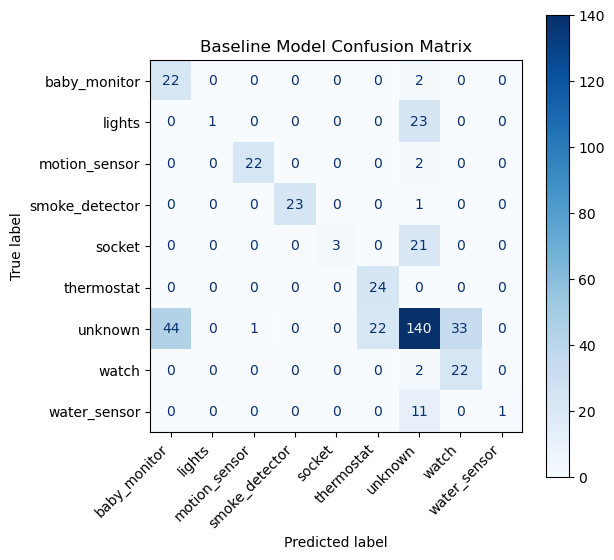

In [47]:
plot_confusion_matrix(y_validation, predictions_v_series, "Baseline Model Confusion Matrix")

#### Observations
The IoT devices of lights, sockets and water sensors have a tendency to be misclassified as unknown.

### Feature Analysis
Analysis of features appears below to determine if low impact features can be excluded from machine learning models.

#### SelectKBest

In [51]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

all_columns_count = X_train.shape[1]
select_k_best = SelectKBest(mutual_info_classif, k=all_columns_count).set_output(transform="pandas")
X_kbest = select_k_best.fit_transform(X_train, y_train)
print(f'X_kbest.shape: {X_kbest.shape}')
print(f'y.shape: {y_train.shape}')


X_kbest.shape: (1200, 253)
y.shape: (1200,)


In [52]:
X_kbest.head(1)

,ack,ack_A,ack_B,bytes,bytes_A,bytes_A_B_ratio,bytes_B,ds_field_B,duration,http_GET,...,subdomain_is_www.cloud,domain_is_dlink,domain_is_else,domain_is_google,domain_is_proteussensor,domain_is_unresolved,suffix_is_com,suffix_is_else,suffix_is_empty_char_value,suffix_is_unresolved
458,25,13,12,5241,2574,0.965129,2667,0,5.3165,0,...,0,0,1,0,0,0,0,0,1,0


<class 'numpy.ndarray'>


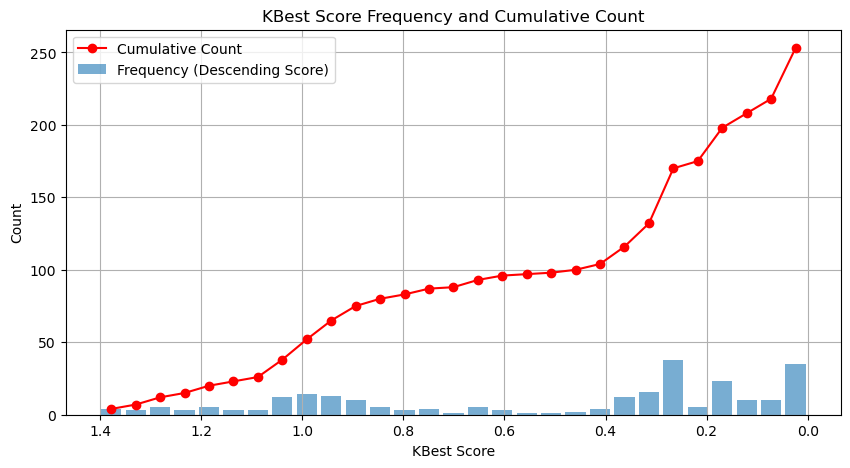

In [53]:
plot_kbest_scores(select_k_best)

The plot `KBest Score Frequency and Cumulative Count` displays the distribution of KBest feature scores. The higher KBest score indicates a higher correlation of a feature to the target value. KBest scores can provide an indication of low value features that can be excluded from the model. The x-axis is reversed so the cumulative count represents the count of features from high to low KBest value.